In [1]:
import numpy as np
import Dataset.Filereaders.read_h5 as read_h5 
import matplotlib.pyplot as plt
from Utils.image_slices import image_slices
from Utils.fft_2d_img import fft_2d_img
from numpy.fft import fft2, fftshift, ifftshift

In [2]:
reader = read_h5.h5_reader("C:\\Users\\brend\\Documents\\fastMRI_subset\\file_brain_AXFLAIR_201_6002902.h5")
k_space = np.array(reader.read_k_space())

In [3]:
k_space = k_space.transpose((1, 2, 3, 0))
kernel = [5, 5]
kx, ky = k_space.shape[1] - kernel[0] + 1, k_space.shape[2] - kernel[1] + 1

In [4]:
%load_ext autoreload
%autoreload 2 

In [5]:
# Dimension is Nc, Kx, Ky, Kz
print(k_space.shape)
ACS = k_space[:, 200:440, 150:170, :]
# Dimension is Nc, Kx, Ky, Kz
print(ACS.shape)

(20, 640, 320, 14)
(20, 240, 20, 14)


In [6]:
import Utils.sens as ss

maps = ss.espirit(ACS)

In [7]:
# Get dimensions
Nc = ACS.shape[0]
Nz = ACS.shape[3]
Kx_acs = ACS.shape[1]-kernel[0]+1
Ky_acs = ACS.shape[2]-kernel[1]+1

H = np.zeros((np.prod(kernel)*Nc, Kx_acs*Ky_acs), dtype='complex')
for i in range(Kx_acs):
    for j in range(Ky_acs):
        # Populate Hankel matrix
        H[:,i*Ky_acs+j] = ACS[:,i:i+kernel[0],j:j+kernel[1],0].flatten()
H = H.transpose()

In [8]:
U, s, vh =np.linalg.svd(H)

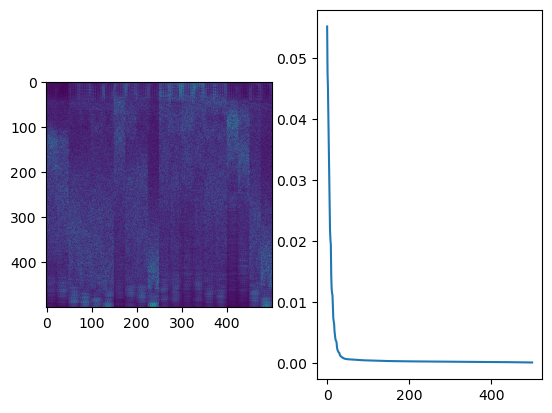

In [9]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.abs(vh))
ax[1].plot(np.abs(s))
plt.show()

In [10]:
v_row = vh[s>s[0]*0.02, :]
v_null = vh[s<s[0]*0.02, :]

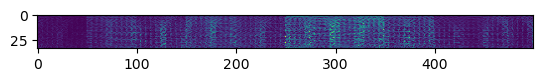

In [11]:
plt.imshow(np.abs(v_row))

In [12]:
plt.imshow(np.abs(v_conv[0, :, :, :].reshape(20, )))

NameError: name 'v_conv' is not defined

In [13]:
v_conv = v_row.reshape(-1, Nc, kernel[0], kernel[1])

In [14]:
pad_x = [np.ceil((kx-kernel[0])/2).astype(int), np.floor((kx-kernel[0])/2).astype(int)]
pad_y = [np.ceil((ky-kernel[1])/2).astype(int), np.floor((ky-kernel[1])/2).astype(int)]

In [15]:
v_covn_pad = np.pad(v_conv, ([0, 0], [0, 0], pad_x, pad_y))

In [16]:
conv_kernel = fftshift(fft2(ifftshift(v_covn_pad, axes=[2, 3]), axes=[2, 3]), axes=[2, 3])

In [17]:
sens = np.zeros(conv_kernel.shape[1:], dtype=np.complex128)

In [18]:
conv_kernel.shape

(34, 20, 636, 316)

In [25]:
for i in range(conv_kernel.shape[2]):
    for j in range(conv_kernel.shape[3]):
        matrix = conv_kernel[:, :, i, j].transpose((1, 0))
        U, S, V = np.linalg.svd(matrix)
        sens[:, i, j] = U[:, 0]
        

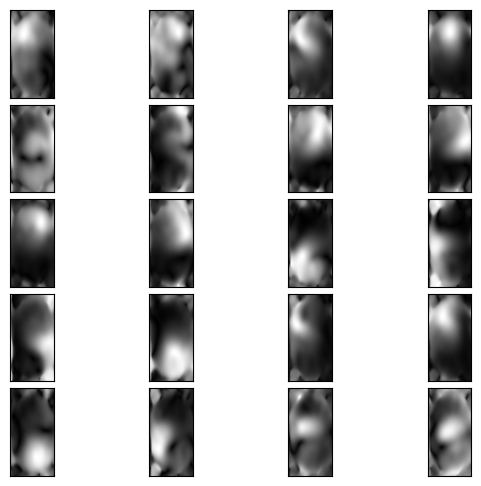

In [26]:
image_slices(sens, cmap='gray')